# Time interpolation

In [1]:
import numpy as np
import mikeio

In [2]:
ds = mikeio.read("../data/waves.dfs2")
ds

<mikeio.Dataset>
dims: (time:3, y:31, x:31)
time: 2004-01-01 00:00:00 - 2004-01-03 00:00:00 (3 records)
geometry: Grid2D (ny=31, nx=31)
items:
  0:  Sign. Wave Height <Significant wave height> (meter)
  1:  Peak Wave Period <Wave period> (second)
  2:  Mean Wave Direction <Mean Wave Direction> (degree)

## Interpolate to specific timestep

A common use case is to interpolate to a shorter timestep, in this case
1h.

In [3]:
ds_h = ds.interp_time(3600)
ds_h

<mikeio.Dataset>
dims: (time:49, y:31, x:31)
time: 2004-01-01 00:00:00 - 2004-01-03 00:00:00 (49 records)
geometry: Grid2D (ny=31, nx=31)
items:
  0:  Sign. Wave Height <Significant wave height> (meter)
  1:  Peak Wave Period <Wave period> (second)
  2:  Mean Wave Direction <Mean Wave Direction> (degree)

And to store the interpolated data in a new file.

In [4]:
ds_h.to_dfs("waves_3h.dfs2")

## Interpolate to time axis of another dataset

Read some non-equidistant data typically found in observed data.

In [5]:
ts = mikeio.read("../data/waves.dfs0")
ts

<mikeio.Dataset>
dims: (time:24)
time: 2004-01-01 01:00:00 - 2004-01-03 12:00:10 (24 non-equidistant records)
geometry: GeometryUndefined()
items:
  0:  Sign. Wave Height <Undefined> (undefined)
  1:  Peak Wave Period <Undefined> (undefined)
  2:  Mean Wave Direction <Undefined> (undefined)

The observed timeseries is longer than the modelled data. Default is to
fill values with NaN.

In [6]:
dsi = ds.interp_time(ts)

In [7]:
dsi.time

DatetimeIndex(['2004-01-01 01:00:00', '2004-01-01 02:00:00',
               '2004-01-01 03:00:00', '2004-01-01 04:00:00',
               '2004-01-01 05:00:00', '2004-01-01 06:00:00',
               '2004-01-01 07:00:00', '2004-01-01 08:00:00',
               '2004-01-01 23:00:00', '2004-01-02 00:00:00',
               '2004-01-02 01:00:00', '2004-01-02 02:00:00',
               '2004-01-02 03:00:00', '2004-01-02 04:00:00',
               '2004-01-02 05:00:00', '2004-01-02 06:00:00',
               '2004-01-02 07:00:00', '2004-01-02 08:00:00',
               '2004-01-02 09:00:00', '2004-01-02 20:00:00',
               '2004-01-02 21:00:00', '2004-01-02 23:00:00',
               '2004-01-03 00:00:00', '2004-01-03 12:00:10'],
              dtype='datetime64[ns]', freq=None)

In [8]:
dsi["Sign. Wave Height"].shape

(24, 31, 31)

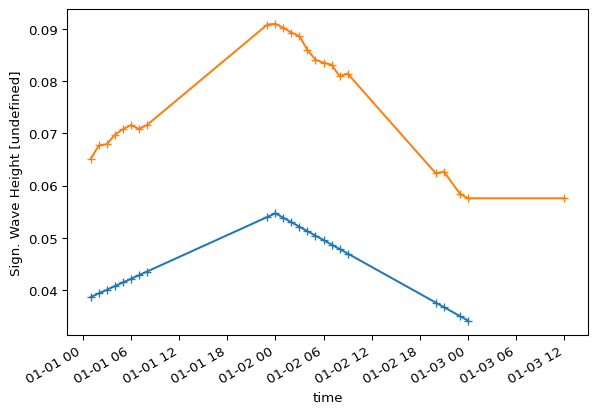

In [9]:
ax = dsi["Sign. Wave Height"].sel(x=250, y=1200).plot(marker='+')
ts["Sign. Wave Height"].plot(ax=ax,marker='+')

## Model validation

A common metric for model validation is mean absolute error (MAE).

In the example below we calculate this metric using the model data
interpolated to the observed times.

For a more elaborate model validation library which takes care of these
things for you as well as calculating a number of relevant metrics, take
a look at [ModelSkill](https://dhi.github.io/modelskill).

Use `np.nanmean` to skip NaN.

In [10]:
ts["Sign. Wave Height"]

<mikeio.DataArray>
name: Sign. Wave Height
dims: (time:24)
time: 2004-01-01 01:00:00 - 2004-01-03 12:00:10 (24 non-equidistant records)
geometry: GeometryUndefined()
values: [0.06521, 0.06771, ..., 0.0576]

In [11]:
dsi["Sign. Wave Height"].sel(x=250, y=1200)

<mikeio.DataArray>
name: Sign. Wave Height
dims: (time:24)
time: 2004-01-01 01:00:00 - 2004-01-03 12:00:10 (24 non-equidistant records)
geometry: GeometryPoint2D(x=275.0, y=1225.0)
values: [0.0387, 0.03939, ..., nan]

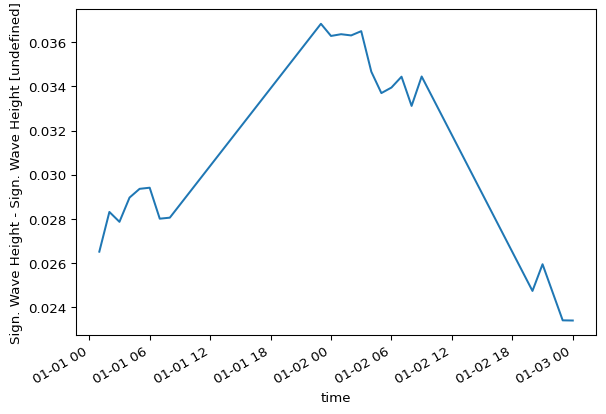

In [12]:
diff = (ts["Sign. Wave Height"]  - dsi["Sign. Wave Height"].sel(x=250, y=1200))
diff.plot()

In [13]:
mae = np.abs(diff).nanmean().to_numpy()
mae

np.float64(0.030895043650399082)

# Clean up

In [14]:
import os
os.remove("waves_3h.dfs2")